# 1 Imports

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

from ev_load_fc.preprocessing.loading import col_standardisation
from ev_load_fc.preprocessing.analysis import ts_completeness, plot_time_series
from ev_load_fc.preprocessing.preprocessing import mad_outlier_bounds
from ev_load_fc.config import CFG, resolve_path
raw_data_path = resolve_path(CFG["paths"]["raw_data"])
ev_raw_filename = CFG["data"]["ev_filename"]

In [2]:
ev_data = pd.read_csv(raw_data_path / ev_raw_filename)

C:\Users\Cameron\AppData\Local\Temp\ipykernel_18328\226665047.py:1: DtypeWarning: Columns (29,30,32) have mixed types. Specify dtype option on import or set low_memory=False.
  ev_data = pd.read_csv(raw_data_path / ev_raw_filename)


# 2 Formatting

In [3]:
ev_data.head()

,Station Name,MAC Address,Org Name,Start Date,Start Time Zone,End Date,End Time Zone,Transaction Date (Pacific Time),Total Duration (hh:mm:ss),Charging Time (hh:mm:ss),...,Longitude,Currency,Fee,Ended By,Plug In Event Id,Driver Postal Code,User ID,County,System S/N,Model Number
0,PALO ALTO CA / HAMILTON #1,000D:6F00:015A:9D76,City of Palo Alto,7/29/2011 20:17,PDT,7/29/2011 23:20,PDT,7/29/2011 23:20,3:03:32,1:54:03,...,-122.160309,USD,0.0,Plug Out at Vehicle,3,95124.0,3284.0,NaN,NaN,NaN
1,PALO ALTO CA / HAMILTON #1,000D:6F00:015A:9D76,City of Palo Alto,7/30/2011 0:00,PDT,7/30/2011 0:02,PDT,7/30/2011 0:02,0:02:06,0:01:54,...,-122.160309,USD,0.0,Customer,4,94301.0,4169.0,NaN,NaN,NaN
2,PALO ALTO CA / HAMILTON #1,000D:6F00:015A:9D76,City of Palo Alto,7/30/2011 8:16,PDT,7/30/2011 12:34,PDT,7/30/2011 12:34,4:17:32,4:17:28,...,-122.160309,USD,0.0,Plug Out at Vehicle,5,94301.0,4169.0,NaN,NaN,NaN
3,PALO ALTO CA / HAMILTON #1,000D:6F00:015A:9D76,City of Palo Alto,7/30/2011 14:51,PDT,7/30/2011 16:55,PDT,7/30/2011 16:55,2:03:24,2:02:58,...,-122.160309,USD,0.0,Customer,6,94302.0,2545.0,NaN,NaN,NaN
4,PALO ALTO CA / HAMILTON #1,000D:6F00:015A:9D76,City of Palo Alto,7/30/2011 18:51,PDT,7/30/2011 20:03,PDT,7/30/2011 20:03,1:11:24,0:43:54,...,-122.160309,USD,0.0,Plug Out at Vehicle,7,94043.0,3765.0,NaN,NaN,NaN


In [3]:
# Convert all column names to lower case, with words only separated by underscores and cutting out text in brackets
ev_data = col_standardisation(ev_data)

ev_data.columns

Index(['station_name', 'mac_address', 'org_name', 'start_date',
       'start_time_zone', 'end_date', 'end_time_zone', 'transaction_date',
       'total_duration', 'charging_time', 'energy', 'ghg_savings',
       'gasoline_savings', 'port_type', 'port_number', 'plug_type', 'evse_id',
       'address_1', 'city', 'state_province', 'postal_code', 'country',
       'latitude', 'longitude', 'currency', 'fee', 'ended_by',
       'plug_in_event_id', 'driver_postal_code', 'user_id', 'county',
       'system_s_n', 'model_number'],
      dtype='object')

In [4]:
# Convert all date columns to pandas datetime
date_cols = ['start_date','end_date','transaction_date']
for col in date_cols:
    ev_data[col] = pd.to_datetime(ev_data[col], format="%m/%d/%Y %H:%M", errors='coerce')
    
ev_data.dtypes

station_name                  object
mac_address                   object
org_name                      object
start_date            datetime64[ns]
start_time_zone               object
end_date              datetime64[ns]
end_time_zone                 object
transaction_date      datetime64[ns]
total_duration                object
charging_time                 object
energy                       float64
ghg_savings                  float64
gasoline_savings             float64
port_type                     object
port_number                    int64
plug_type                     object
evse_id                      float64
address_1                     object
city                          object
state_province                object
postal_code                    int64
country                       object
latitude                     float64
longitude                    float64
currency                      object
fee                          float64
ended_by                      object
p

# 3 Initial Checks

In [6]:
ev_data.describe()

,start_date,end_date,transaction_date,energy,ghg_savings,gasoline_savings,port_number,evse_id,postal_code,latitude,longitude,fee,plug_in_event_id,driver_postal_code,system_s_n
count,259415,259375,259166,259415.000000,259415.000000,259415.000000,259415.000000,1.804670e+05,259415.000000,259415.000000,259415.000000,259415.000000,2.594150e+05,251013.000000,1.804670e+05
mean,2017-06-15 03:19:32.322957568,2017-06-15 05:55:17.193484544,2017-06-15 01:37:29.294351616,8.544277,3.588596,1.072306,1.591627,1.462973e+05,94302.315768,37.439565,-122.151264,1.097481,1.188685e+08,94170.308255,1.443790e+11
min,2011-07-29 20:17:00,2011-07-29 23:20:00,2011-07-29 23:20:00,0.010000,0.004000,0.001000,1.000000,3.792000e+03,94301.000000,37.422104,-122.163239,0.000000,1.000000e+00,1013.000000,1.023100e+11
25%,2016-04-12 21:31:00,2016-04-12 22:29:00,2016-04-12 16:57:00,3.784000,1.589000,0.475000,1.000000,4.358300e+04,94301.000000,37.428318,-122.162170,0.000000,1.573000e+03,94087.000000,1.231100e+11
50%,2017-07-15 10:51:00,2017-07-15 13:32:00,2017-07-14 20:55:00,6.868634,2.885000,0.862000,2.000000,1.074270e+05,94301.000000,37.444489,-122.158272,0.000000,3.573000e+03,94304.000000,1.427410e+11
75%,2019-01-25 08:33:30,2019-01-25 12:10:30,2019-01-25 12:38:15,11.458340,4.813000,1.438000,2.000000,1.745590e+05,94303.000000,37.446613,-122.145699,1.640000,6.340000e+03,94804.000000,1.705410e+11
max,2020-12-31 18:19:00,2021-01-04 21:01:00,2021-01-04 21:03:00,97.360000,40.891000,12.219000,2.000000,5.535441e+06,94306.000000,37.449375,-122.112480,84.560000,1.609436e+09,99354.000000,2.002410e+11
std,NaN,NaN,NaN,7.185462,3.017894,0.901776,0.491534,2.429677e+05,1.941657,0.009621,0.015382,1.934408,4.057750e+08,4249.837126,2.483280e+10


In [7]:
# Total unique EV sessions
print(f"Total unique EV sessions: {ev_data['plug_in_event_id'].nunique()}")

Total unique EV sessions: 36838


In [8]:
# Unique values per column
ev_data.nunique()

station_name              47
mac_address               83
org_name                   2
start_date            244798
start_time_zone            3
end_date              244119
end_time_zone              3
transaction_date      240865
total_duration         31025
charging_time          22473
energy                118061
ghg_savings            15535
gasoline_savings        6333
port_type                  2
port_number                2
plug_type                  2
evse_id                   51
address_1                 20
city                       1
state_province             1
postal_code                3
country                    1
latitude                  62
longitude                 64
currency                   4
fee                     1817
ended_by                  16
plug_in_event_id       36838
driver_postal_code       985
user_id                27698
county                     2
system_s_n                81
model_number              10
dtype: int64

In [ ]:
# Missings breakdown
ev_data.isnull().sum() 

station_name              0
mac_address               0
org_name                  0
start_date                0
start_time_zone           0
end_date                 40
end_time_zone             0
transaction_date        249
total_duration            0
charging_time             0
energy                    0
ghg_savings               0
gasoline_savings          0
port_type                 9
port_number               0
plug_type                 0
evse_id               78948
address_1                 0
city                      0
state_province            0
postal_code               0
country                   0
latitude                  0
longitude                 0
currency               1788
fee                       0
ended_by                248
plug_in_event_id          0
driver_postal_code     8402
user_id                7677
county                84665
system_s_n            78948
model_number          78948
dtype: int64

In [5]:
# Duplicates
ev_data[ev_data.duplicated()]

,station_name,mac_address,org_name,start_date,start_time_zone,end_date,end_time_zone,transaction_date,total_duration,charging_time,...,longitude,currency,fee,ended_by,plug_in_event_id,driver_postal_code,user_id,county,system_s_n,model_number
32434,PALO ALTO CA / MPL #6,000D6F00015B7509,City of Palo Alto,2015-02-25 15:24:00,PST,2015-02-25 15:46:00,PST,2015-02-25 15:46:00,0:22:23,0:22:10,...,-122.113457,USD,0.00,Plug Out at Vehicle,469,95134.0,318799.0,NaN,NaN,NaN
108236,PALO ALTO CA / HIGH #2,0024:B100:0002:5959,City of Palo Alto,2017-02-27 11:14:00,PST,2017-02-27 14:17:00,PST,2017-02-27 14:17:00,3:02:42,2:33:45,...,-122.163017,USD,0.00,Plug Out at Vehicle,1488222853,94301.0,738281,Santa Clara County,1.640410e+11,CT4020-HD
109967,PALO ALTO CA / BRYANT #2,000D:6F00:009D:CFC3,City of Palo Alto,2017-03-10 14:07:00,PST,2017-03-10 15:53:00,PST,2017-03-10 15:53:00,1:46:01,1:24:31,...,-122.162140,USD,0.00,Customer,9453,94065.0,548777,Santa Clara County,1.023100e+11,CT2100-HD-CCR
206765,PALO ALTO CA / BRYANT #5,0024:B100:0002:6D51,City of Palo Alto,2019-04-29 08:10:00,PDT,2019-04-29 09:09:00,PDT,2019-04-29 09:10:00,0:59:06,0:57:54,...,-122.162231,USD,1.33,Plug Out at Vehicle,3413,94027.0,4516921.0,Santa Clara County,1.707410e+11,CT4020-HD


In [6]:
# Drop duplicates
ev_data.drop_duplicates(inplace=True)

## Distribution of energy load per session

In [6]:
negative_e_load = ev_data[ev_data['energy']<0]['energy'].count()
print(f"Number of charging events with negative energy loads: {negative_e_load}")

Number of charging events with negative energy loads: 0


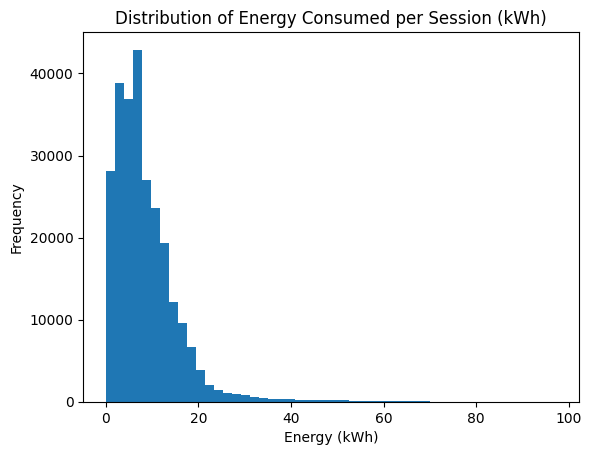

In [ ]:
plt.hist(ev_data['energy'],bins=50)
plt.title('Distribution of Energy Consumed per Session (kWh)')
plt.xlabel('Energy (kWh)')
plt.ylabel('Frequency')
plt.show()

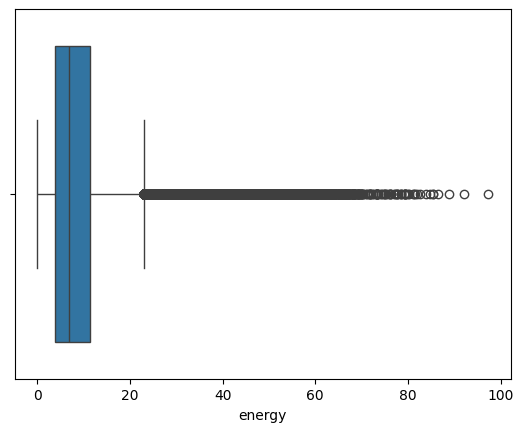

In [ ]:
sns.boxplot(x=ev_data['energy'])
plt.show()

In [ ]:
# Outlier detection using MAD
MAD_dict = mad_outlier_bounds(ev_data, 'energy', threshold=4)
print(MAD_dict)

{'energy': {'median': np.float64(6.86892), 'skewed': True, 'max_val': np.float64(25.228256), 'min_val': np.float64(-5.470760000000001)}}


# 4 Time series graphs

In [ ]:
# Create additional time-based columns
ev_data['month'] = ev_data['start_date'].dt.to_period('M')
ev_data['date'] = ev_data['start_date'].dt.date
ev_data['hourly_datetime'] = ev_data['start_date'].dt.round('h')
ev_data['weekday'] = ev_data['start_date'].dt.dayofweek

## Monthly Plots

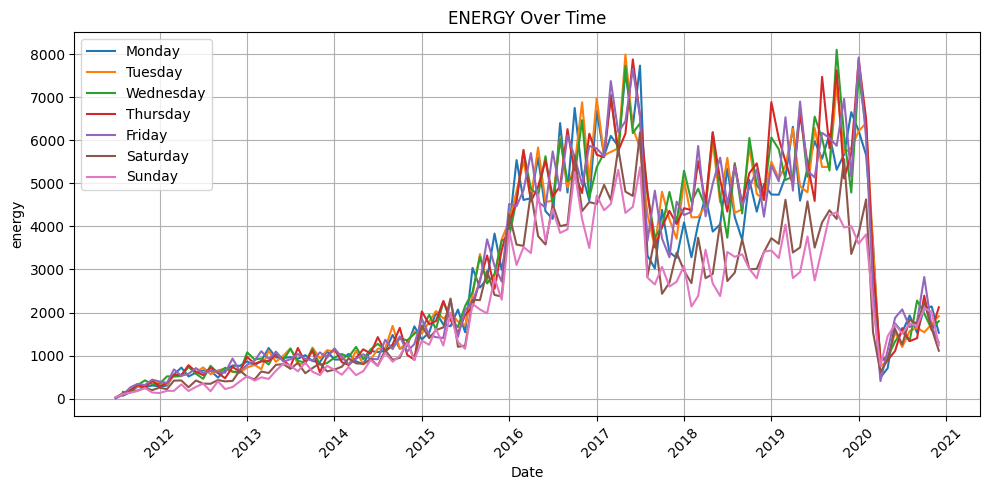

In [ ]:
# Plot time series of ev charging event load per month (kWH)
plot_time_series(ev_data, 'month', 'energy', weekday_split=True)

## Hourly Plots

C:\Users\Cameron\projects\ev_load_fc\src\ev_load_fc\data\loading.py:103: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


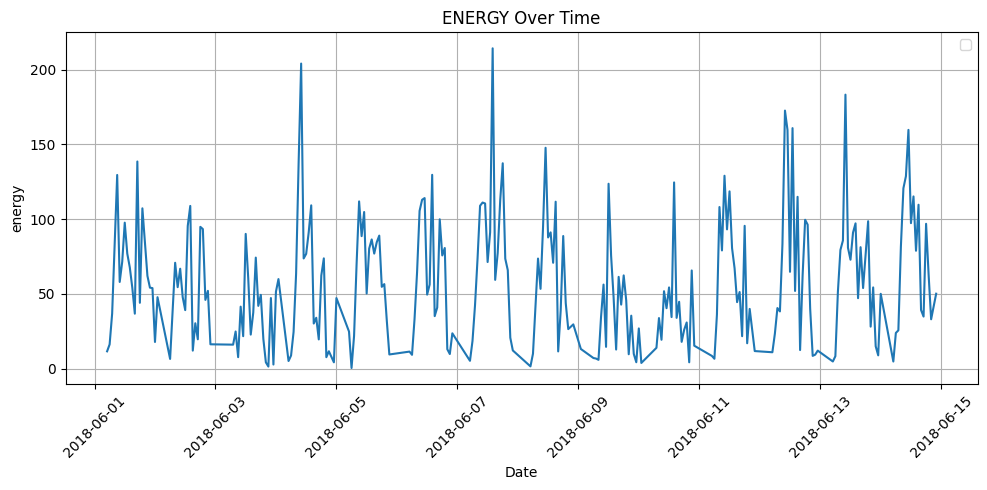

In [ ]:
hourly_date_condition = (datetime(2018,6,1).date() <= ev_data['date']) & (ev_data['date'] < datetime(2018,6,15).date())
# Plot time series of ev charging event load per hour (kWH)
plot_time_series(ev_data[hourly_date_condition], 'hourly_datetime', 'energy')

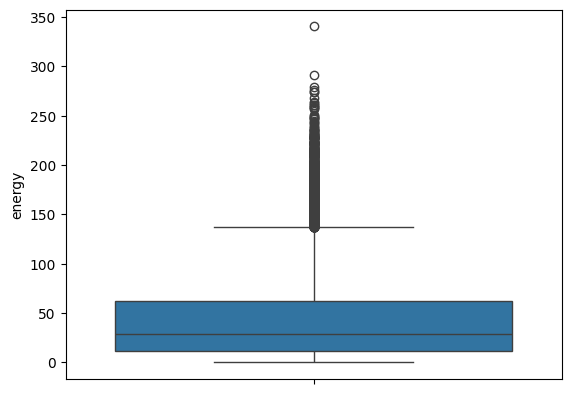

In [ ]:
hourly_energy = pd.DataFrame(ev_data.groupby(by=['hourly_datetime'],sort=True)['energy'].sum().reset_index(), columns=['date','energy'])
sns.boxplot(hourly_energy['energy'])
plt.show()

In [ ]:
# Outlier detection using MAD
print(mad_outlier_bounds(hourly_energy, 'energy', threshold=4))

{'energy': {'median': np.float64(28.241082499999997), 'skewed': True, 'max_val': np.float64(162.4810645), 'min_val': np.float64(-37.8947935)}}


## Daily Plots

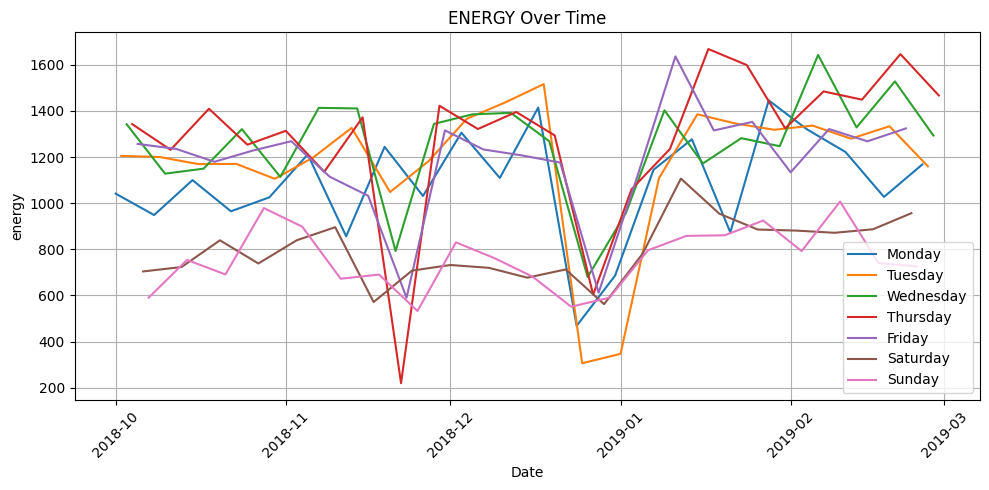

In [ ]:
daily_date_condition = (datetime(2018,10,1).date() <= ev_data['date']) & (ev_data['date'] < datetime(2019,3,1).date())
# Plot time series of ev charging event load per day (kWH)
plot_time_series(ev_data[daily_date_condition], 'date', 'energy', weekday_split=True)

# 5 Time series completeness for different aggregations

## 5.1 All charging stations

In [ ]:
num_days = (ev_data['start_date'].max() - ev_data['start_date'].min()) // pd.Timedelta(days=1)
print(f"Number of days in dataset: {num_days}")

Number of days in dataset: 3442


In [ ]:
num_hours = (ev_data['start_date'].max() - ev_data['start_date'].min()) // pd.Timedelta(hours=1)
print(f"Number of hours in dataset: {num_hours}")

Number of hours in dataset: 82630


In [ ]:
# Calculate ratio of days with at least one EV session to total days in dataset
daily_cr = ts_completeness(ev_data, 'D', 1, 'start_date')
print(f"Daily completeness ratio: {daily_cr:.1%}")

Daily completeness ratio: 100.0%


In [ ]:
# Calculate ratio of n-hour periods with at least one EV session to total n-hour periods in dataset

hourly_cr = ts_completeness(ev_data, 'h', 1, 'start_date')
print(f"Hourly completeness ratio: {hourly_cr:.1%}")

hourly_2_cr = ts_completeness(ev_data, 'h', 2, 'start_date')
print(f"2-hourly completeness ratio: {hourly_2_cr:.1%}")

hourly_3_cr = ts_completeness(ev_data, 'h', 3, 'start_date')
print(f"3-hourly completeness ratio: {hourly_3_cr:.1%}")

hourly_4_cr = ts_completeness(ev_data, 'h', 4, 'start_date')
print(f"4-hourly completeness ratio: {hourly_4_cr:.1%}")

hourly_6_cr = ts_completeness(ev_data, 'h', 6, 'start_date')
print(f"6-hourly completeness ratio: {hourly_6_cr:.1%}")

Hourly completeness ratio: 64.7%
2-hourly completeness ratio: 74.8%
3-hourly completeness ratio: 80.6%
4-hourly completeness ratio: 83.4%
6-hourly completeness ratio: 90.7%


In [ ]:
## For each hour across full time series, count number of EV sessions starting in that hour
# Round start_date to the nearest hour
ev_data['nhd'] = ev_data['start_date'].dt.round('h')
# Group by hourly_datetime and count number of sessions per hour
hd = ev_data.groupby(by=['nhd'],sort=True).count()
# Count charging occurrences of each hour and normalised count by total number of hours in dataset
charges_per_hour = hd.index.hour.value_counts().sort_index().reset_index()
charges_per_hour['normalised_count'] = round(charges_per_hour['count'] / (num_hours/24), 3)
charges_per_hour

,nhd,count,normalised_count
0,0,695,0.202
1,1,274,0.080
2,2,157,0.046
3,3,131,0.038
4,4,226,0.066
5,5,1386,0.403
6,6,2291,0.665
7,7,2665,0.774
8,8,2926,0.850
9,9,3135,0.911


## 5.2 By individual charging station

In [ ]:
ev_data['station_name'].value_counts().sort_index()

station_name
PALO ALTO CA / BRYANT # 1            13
PALO ALTO CA / BRYANT #1          13436
PALO ALTO CA / BRYANT #2          14389
PALO ALTO CA / BRYANT #3           4475
PALO ALTO CA / BRYANT #4           3598
PALO ALTO CA / BRYANT #5           5332
PALO ALTO CA / BRYANT #6           5857
PALO ALTO CA / CAMBRIDGE #1       11163
PALO ALTO CA / CAMBRIDGE #2        9256
PALO ALTO CA / CAMBRIDGE #3        4476
PALO ALTO CA / CAMBRIDGE #4        3428
PALO ALTO CA / CAMBRIDGE #5        4556
PALO ALTO CA / HAMILTON #1        14888
PALO ALTO CA / HAMILTON #2        23721
PALO ALTO CA / HIGH #1            10756
PALO ALTO CA / HIGH #2             6930
PALO ALTO CA / HIGH #3             8317
PALO ALTO CA / HIGH #4            13898
PALO ALTO CA / MPL #1              1044
PALO ALTO CA / MPL #2              1535
PALO ALTO CA / MPL #3              1420
PALO ALTO CA / MPL #4              7787
PALO ALTO CA / MPL #5              7544
PALO ALTO CA / MPL #6              8996
PALO ALTO CA / RINCONADA LI

In [ ]:
ev_data['station_group'] = ev_data['station_name'].apply(lambda x: x[14:x.find('#')].strip())
ev_data['station_group'].value_counts().sort_index()

station_group
BRYANT           47100
CAMBRIDGE        32879
HAMILTON         38609
HIGH             39901
MPL              28326
RINCONADA LIB    18264
SHERMAN             34
SHERMAN 1            5
TED THOMPSON     16712
WEBSTER          37585
Name: count, dtype: int64

In [ ]:
ev_data = ev_data[~ev_data["station_group"].str.contains("SHERMAN", na=False)]

In [ ]:
for sg in ev_data['station_group'].unique():
    ev_data_sg = ev_data[ev_data['station_group']==sg]

    print(f"Completeness ratios for station group {sg}:")

    sg_daily_cr = ts_completeness(ev_data_sg, 'D', 1, 'start_date')
    print(f"Daily completeness ratio: {sg_daily_cr:.1%}")

    sg_hourly_cr = ts_completeness(ev_data_sg, 'h', 1, 'start_date')
    print(f"Hourly completeness ratio: {sg_hourly_cr:.1%}")

    sg_hourly_2_cr = ts_completeness(ev_data_sg, 'h', 2, 'start_date')
    print(f"2-hourly completeness ratio: {sg_hourly_2_cr:.1%}")

    sg_hourly_3_cr = ts_completeness(ev_data_sg, 'h', 3, 'start_date')
    print(f"3-hourly completeness ratio: {sg_hourly_3_cr:.1%}")

    sg_hourly_4_cr = ts_completeness(ev_data_sg, 'h', 4, 'start_date')
    print(f"4-hourly completeness ratio: {sg_hourly_4_cr:.1%}")

    sg_hourly_6_cr = ts_completeness(ev_data_sg, 'h', 6, 'start_date')
    print(f"6-hourly completeness ratio: {sg_hourly_6_cr:.1%}")

    sg_hourly_12_cr = ts_completeness(ev_data_sg, 'h', 12, 'start_date')
    print(f"12-hourly completeness ratio: {sg_hourly_12_cr:.1%}")

    print("------------------------------------------------")

Completeness ratios for station group HAMILTON:
Daily completeness ratio: 99.6%
Hourly completeness ratio: 35.7%
2-hourly completeness ratio: 54.6%
3-hourly completeness ratio: 64.6%
4-hourly completeness ratio: 70.3%
6-hourly completeness ratio: 79.8%
12-hourly completeness ratio: 97.5%
------------------------------------------------
Completeness ratios for station group HIGH:
Daily completeness ratio: 98.3%
Hourly completeness ratio: 30.9%
2-hourly completeness ratio: 45.8%
3-hourly completeness ratio: 54.9%
4-hourly completeness ratio: 61.9%
6-hourly completeness ratio: 70.6%
12-hourly completeness ratio: 93.6%
------------------------------------------------
Completeness ratios for station group BRYANT:
Daily completeness ratio: 98.8%
Hourly completeness ratio: 37.0%
2-hourly completeness ratio: 52.4%
3-hourly completeness ratio: 60.2%
4-hourly completeness ratio: 67.0%
6-hourly completeness ratio: 72.9%
12-hourly completeness ratio: 96.0%
-----------------------------------------

## 5.3 Over given window

In [ ]:
min_timestamp = datetime(2017,8,1,0,0,0)
max_timestamp = datetime(2020,3,1,0,0,0)
time_window_cond = (min_timestamp<=ev_data['start_date']) & (ev_data['start_date']<max_timestamp)
ev_data_tw = ev_data[time_window_cond]

In [ ]:
# Calculate ratio of days with at least one EV session to total days in dataset
tw_daily_cr = ts_completeness(ev_data_tw, 'D', 1, 'start_date')
print(f"Daily completeness ratio: {tw_daily_cr:.1%}")

Daily completeness ratio: 100.1%


In [ ]:
# Calculate ratio of n-hour periods with at least one EV session to total n-hour periods in dataset

tw_hourly_cr = ts_completeness(ev_data_tw, 'h', 1, 'start_date')
print(f"Hourly completeness ratio: {tw_hourly_cr:.1%}")

tw_hourly_2_cr = ts_completeness(ev_data_tw, 'h', 2, 'start_date')
print(f"2-hourly completeness ratio: {tw_hourly_2_cr:.1%}")

tw_hourly_3_cr = ts_completeness(ev_data_tw, 'h', 3, 'start_date')
print(f"3-hourly completeness ratio: {tw_hourly_3_cr:.1%}")

tw_hourly_4_cr = ts_completeness(ev_data_tw, 'h', 4, 'start_date')
print(f"4-hourly completeness ratio: {tw_hourly_4_cr:.1%}")

tw_hourly_6_cr = ts_completeness(ev_data_tw, 'h', 6, 'start_date')
print(f"6-hourly completeness ratio: {tw_hourly_6_cr:.1%}")

Hourly completeness ratio: 72.7%
2-hourly completeness ratio: 79.9%
3-hourly completeness ratio: 85.4%
4-hourly completeness ratio: 86.6%
6-hourly completeness ratio: 95.4%


# 99 Conclusion  

Since we are constructing a time series by aggregating energy load from individual charging events up to hourly/daily/sub-daily periods, we can consider periods where there is no energy load (i.e. it is "missing" for that hour/day) to have energy load of 0kWH. <br> <br>

From the time series plots in section 4, we can see large regime shifts in mid 2017 and during the start of COVID in early 2020. Therefore a window of 1st August 2017 - 29th February 2020 will be chosen for it's stability. <br> <br>

Modelling multiple time series for each individual charging station may be possible for sub-daily forecasting if they're loads are aggregated to >1hr periods.